# Post analysis of brutal force alternative stable states

Load data and organize them. There are 48 taskes. task_id // 4 is the index for correlation $\rho$, and task_id % 4 is for combinations

In [27]:
import torch
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
from torch import optim


filepath = Path('./data/AltSS/')
num_AltSS = torch.zeros(12)
num_task = 48

for task_id in range(num_task):

    filename = 'AltSSdiv'+str(task_id)+'.pt'
    i = task_id // 4
    num_AltSS[i] = num_AltSS[i] + len(torch.load(filepath/filename)['AltSSdiv'])

C_span = torch.load(Path('./data/')/'AltSSsamples.pt')['C_span']
G_span = torch.load(Path('./data/')/'AltSSsamples.pt')['G_span']

Get $E(G,C)$ for each case.

In [28]:
## this one is used to get CD
class rescale(nn.Module):
    def __init__(self,Nr):
        super(rescale, self).__init__()
        self.D = nn.Parameter(torch.ones(Nr)) # not sure if devided by sqrt(Nr)

    def forward(self, C):
        output = C @ torch.diag(self.D)
        return output

## the following three used for calculating loss function
def NormalG(G):
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G
    return G

def H(G):
    # normaized to the simplex
    Ns = G.size(dim=0)
    G = torch.diag((torch.sum(G, 1))**(-1)) @ G

    # G-G distances
    distances = torch.zeros(Ns,Ns)
    for i in range(Ns-1):
        for j in range(i+1, Ns):
            distances[i,j] = torch.linalg.norm(G[i] - G[j])
    distances = distances + distances.transpose(0,1) + 2*torch.diag(torch.ones(Ns))
    minDis = torch.min(distances, 1).values
    H = torch.mean(minDis)
    return H


def Loss(NG,CD,H):
    # normaized to the simplex
    CD = torch.diag((torch.sum(CD, 1))**(-1)) @ CD

    # G-C distances
    I = torch.mean(torch.linalg.norm(NG - CD, dim=1))

    # G-G distances given by H
    # by definition
    E = I/H
    return E

In [29]:
Nr = 12
lr = 0.1
epochs = 1000
EGC = torch.zeros(12)

for i in range(12):
    G = G_span[i]
    C = C_span[i]
    HG = H(G)
    NorG = NormalG(G)

    layer = rescale(Nr) # get new model!
    opt = optim.SGD(layer.parameters(), lr=lr, momentum=0.9)

    E = 0 # initailize E(G,C)
    # training process
    for epoch in range(epochs):
        CD = layer(C)
        loss = Loss(NorG,CD,HG)

        loss.backward()
        opt.step()
        opt.zero_grad()

        if epoch >= epochs - 100:
            E = (E*(epoch - epochs + 100) + loss.item())/(epoch - epochs + 101)
    
    EGC[i] = E

Number of alternative stable states vs. $E(G,C)$

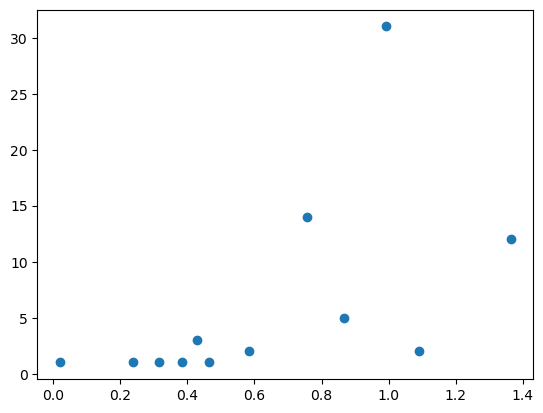

In [31]:
plt.figure()
plt.plot(EGC,num_AltSS,'o')

In [6]:
test_Altdiv = torch.tensor([])
for task_id in range(4):
    filename = 'AltSSdiv'+str(task_id)+'.pt'
    test_Altdiv = torch.cat((test_Altdiv,torch.load(filepath/filename)['AltSSdiv']))

(0.0, 12.0)

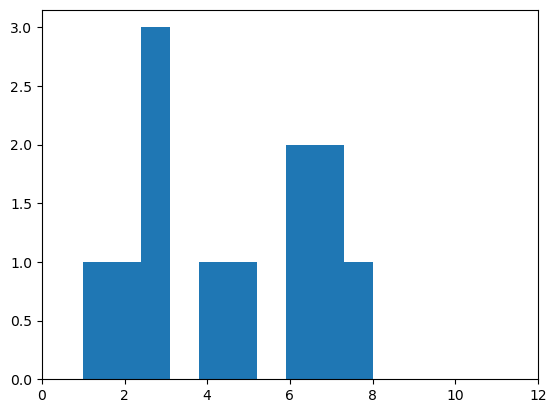

In [10]:
plt.figure()
plt.hist(test_Altdiv)
plt.xlim(0,12)

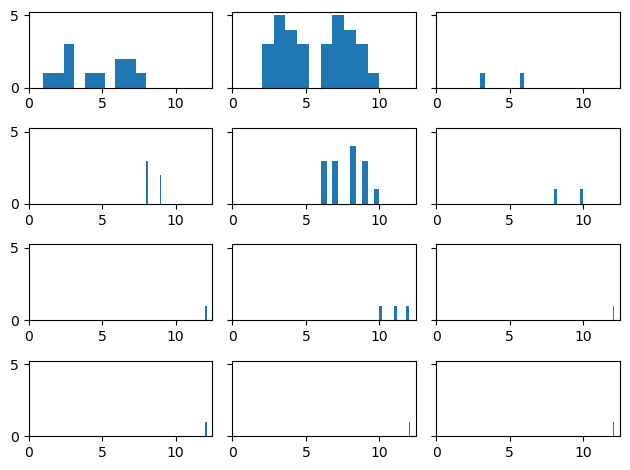

In [22]:
fig, axs = plt.subplots(4, 3, sharey=True, tight_layout=True)

for task_id in range(num_task):

    filename = 'AltSSdiv'+str(task_id)+'.pt'
    if task_id % 4 == 0:
        Altdiv = torch.tensor([])
    Altdiv = torch.cat((Altdiv,torch.load(filepath/filename)['AltSSdiv'])) # type: ignore
    if task_id % 4 == 3:
        axs[(task_id // 4)//3,(task_id // 4) % 3].hist(Altdiv)
        axs[(task_id // 4)//3,(task_id // 4) % 3].set_xlim([0,12.5])